In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [12]:
client1_features = pd.read_csv("../data/client1_hvac.csv")
client2_features = pd.read_csv("../data/client2_solar.csv")
labels = pd.read_csv("../data/labels.csv")

print("Client 1 (HVAC) features:\n", client1_features.head())
print("\nClient 2 (Solar) features:\n", client2_features.head())
print("\nServer labels (design target):\n", labels.head())

Client 1 (HVAC) features:
     avg_temp  energy_consumed  run_hours  cooling_setpoint  heating_setpoint
0  21.872701         5.308767   9.671117         22.822635         18.488153
1  24.753572        19.548648   6.836963         21.511572         19.980708
2  23.659970        17.486640   7.752868         21.195155         18.137554
3  22.993292         8.185087   8.198171         23.846657         21.637282
4  20.780093         7.727375   8.736420         23.896896         19.035120

Client 2 (Solar) features:
    solar_gen  battery_charge  battery_discharge  grid_draw        soc
0  14.543769       43.320637          38.612238   8.631034  19.567540
1  11.626992       36.280942           9.935784   6.232981  67.059583
2  14.092484       69.724251           0.276106   3.308980  70.862804
3  13.422410       41.405200          40.773071   0.635584  54.902176
4   8.968500       36.856071          35.342867   3.109823  71.677374

Server labels (design target):
    solar_for_hvac
0        7.

In [13]:
# ---------------------------
# Step 2: Define clients and server classes
# ---------------------------
class Client:
    def __init__(self, name, features):
        self.name = name
        self.X = features.values
        self.weights = np.random.randn(self.X.shape[1])
    
    def compute_logits(self):
        return self.X @ self.weights
    
    def masked_logits(self):
        self._mask = np.random.randn(self.X.shape[0])
        return self.compute_logits() + self._mask
    
    def update(self, grad, lr=0.01):
        self.weights -= lr * grad

In [14]:
class Server:
    def __init__(self, clients, y):
        self.clients = clients
        self.y = y.values.flatten()
    
    def aggregate(self):
        masked_logits = [c.masked_logits() for c in self.clients]
        combined = np.sum(masked_logits, axis=0)
        # remove mask
        for c in self.clients:
            combined -= c._mask
        return combined
    
    def compute_loss_and_grads(self, logits):
        preds = logits
        loss = np.mean((preds - self.y)**2)
        grad_common = 2 * (preds - self.y) / len(self.y)
        grads = [c.X.T @ grad_common for c in self.clients]
        return loss, grads

In [15]:
# ---------------------------
# Step 3: Initialize clients and server
# ---------------------------
client1 = Client("HVAC", client1_features)
client2 = Client("Solar", client2_features)
server = Server([client1, client2], labels)


In [6]:
# ---------------------------
# Step 4: Training loop
# ---------------------------
n_epochs = 20
losses = []

for epoch in range(n_epochs):
    logits = server.aggregate()
    loss, grads = server.compute_loss_and_grads(logits)
    for c, g in zip([client1, client2], grads):
        c.update(g, lr=0.001)
    losses.append(loss)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 15536.1121
Epoch 2, Loss: 2378746.2935
Epoch 3, Loss: 384726257.9330
Epoch 4, Loss: 62226740314.2073
Epoch 5, Loss: 10064734182003.1758
Epoch 6, Loss: 1627899415409925.7500
Epoch 7, Loss: 263301191941458336.0000
Epoch 8, Loss: 42587101525763252224.0000
Epoch 9, Loss: 6888161815723612569600.0000
Epoch 10, Loss: 1114111350613746263261184.0000
Epoch 11, Loss: 180199614174712978611372032.0000
Epoch 12, Loss: 29146010343424988886222241792.0000
Epoch 13, Loss: 4714160587022186162494657003520.0000
Epoch 14, Loss: 762482061125278259885773175128064.0000
Epoch 15, Loss: 123326068937565536164691559382515712.0000
Epoch 16, Loss: 19947117519259535073807021879022583808.0000
Epoch 17, Loss: 3226304874183442076376952447909144559616.0000
Epoch 18, Loss: 521831945449240675063818651662279952564224.0000
Epoch 19, Loss: 84402618447600643839636741519468142721499136.0000
Epoch 20, Loss: 13651525290730212760222720110530921491408617472.0000


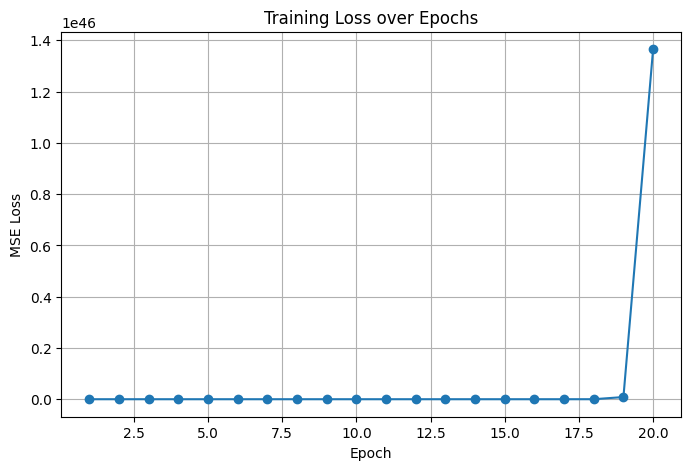

In [7]:
# ---------------------------
# Step 5: Plot training loss
# ---------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

In [8]:
# ---------------------------
# Step 6: Check predictions vs design target
# ---------------------------
final_preds = server.aggregate()
result = pd.DataFrame({
    'predicted_solar_for_hvac': final_preds,
    'design_target': labels['solar_for_hvac']
})
print(result)

   predicted_solar_for_hvac  design_target
0             -1.206238e+24       7.104562
1             -1.528176e+24      12.963414
2             -1.860267e+24      13.062826
3             -1.583980e+24       6.131697
4             -1.658462e+24       6.334565
5             -1.615094e+24       8.381080
6             -1.356625e+24       6.657927
7             -1.564706e+24       6.799326
8             -8.308208e+23       5.134617
9             -1.407989e+24       5.646448


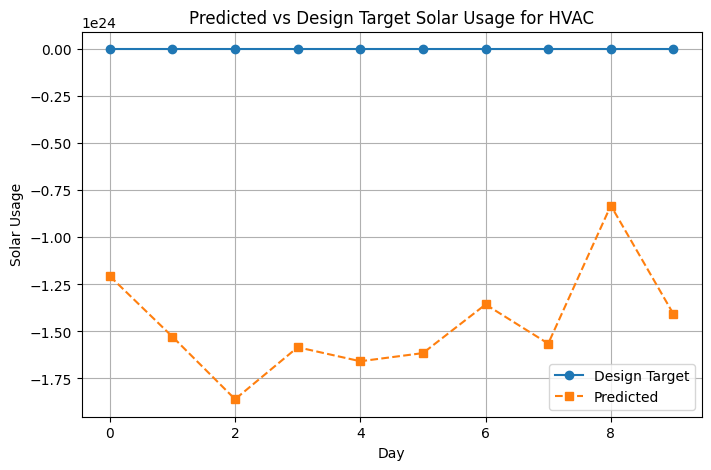

In [9]:
# Optional plot to visualize predictions
plt.figure(figsize=(8,5))
plt.plot(result['design_target'], 'o-', label='Design Target')
plt.plot(result['predicted_solar_for_hvac'], 's--', label='Predicted')
plt.title("Predicted vs Design Target Solar Usage for HVAC")
plt.xlabel("Day")
plt.ylabel("Solar Usage")
plt.legend()
plt.grid(True)
plt.show()